<a href="https://colab.research.google.com/github/TaeGongKim/tensorflow-developer/blob/main/Sequences%2C%20Time%20Series%20and%20Prediction/Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import csv

print(tf.__version__)

2.6.0


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(False)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

--2021-10-29 15:13:58--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-10-29 15:13:58 (4.72 MB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



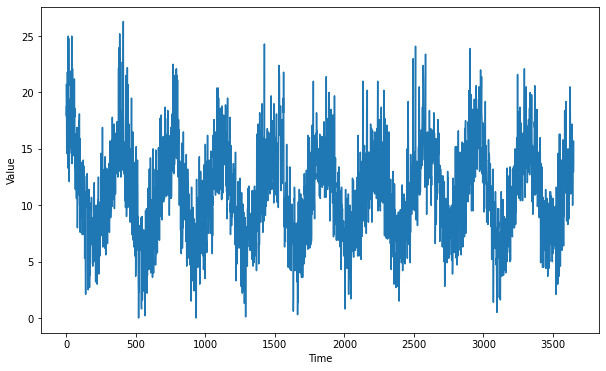

In [ ]:
time_step = []
temps = []

with open('./daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step += 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize = (10, 6))
plot_series(time, series)

In [ ]:
split_time = 2500

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis = -1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
def model_forecast(model, series, window_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(32).prefetch(1)
  forcast = model.predict(dataset)
  return forcast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

Epoch 1/100
10/10 [==============================] - 7s 291ms/step - loss: 31.1418 - mae: 31.6401
Epoch 2/100
10/10 [==============================] - 3s 294ms/step - loss: 30.5656 - mae: 31.0639


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f12d08a0b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 3/100
10/10 [==============================] - 3s 288ms/step - loss: 29.6745 - mae: 30.1726
Epoch 4/100
10/10 [==============================] - 3s 290ms/step - loss: 28.5571 - mae: 29.0549
Epoch 5/100
10/10 [==============================] - 3s 285ms/step - loss: 27.1948 - mae: 27.6923
Epoch 6/100
10/10 [==============================] - 3s 284ms/step - loss: 25.4979 - mae: 25.9952
Epoch 7/100
10/10 [==============================] - 3s 282ms/step - loss: 23.3389 - mae: 23.8356
Epoch 8/100
10/10 [==============================] - 3s 286ms/step - loss: 20.5994 - mae: 21.0955
Epoch 9/100
10/10 [==============================] - 3s 283ms/step - loss: 17.2908 - mae: 17.7858
Epoch 10/100
10/10 [==============================] - 3s 283ms/step - loss: 13.6042 - mae: 14.0969
Epoch 11/100
10/10 [==============================] - 3s 286ms/step - loss: 10.0206 - mae: 10.5085
Epoch 12/100
10/10 [==============================] - 3s 282ms/step - loss: 7.4651 - mae: 7.9498
Epoch 13/100
10/10 

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 34s 56ms/step - loss: 31.1418 - mae: 31.6401
Epoch 2/100
10/10 [==============================] - 1s 49ms/step - loss: 30.5657 - mae: 31.0639
Epoch 3/100
10/10 [==============================] - 1s 54ms/step - loss: 29.6745 - mae: 30.1726
Epoch 4/100
10/10 [==============================] - 1s 49ms/step - loss: 28.5571 - mae: 29.0549
Epoch 5/100
10/10 [==============================] - 1s 52ms/step - loss: 27.1948 - mae: 27.6923
Epoch 6/100
10/10 [==============================] - 1s 52ms/step - loss: 25.4979 - mae: 25.9952
Epoch 7/100
10/10 [==============================] - 1s 51ms/step - loss: 23.3389 - mae: 23.8356
Epoch 8/100
10/10 [==============================] - 1s 51ms/step - loss: 20.5994 - mae: 21.0955
Epoch 9/100
10/10 [==============================] - 1s 53ms/step - loss: 17.2908 - mae: 17.7857
Epoch 10/100
10/10 [==============================] - 1s 54ms/step - loss: 13.6041 - mae: 14.0968
Epoch 11/100
10/10 [========

(1e-08, 0.0001, 0.0, 60.0)

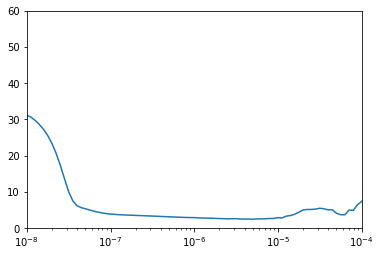

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)# YOUR CODE HERE)

# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 5s 36ms/step - loss: 9.8779 - mae: 10.3645
Epoch 2/150
25/25 [==============================] - 1s 36ms/step - loss: 2.7308 - mae: 3.1968
Epoch 3/150
25/25 [==============================] - 1s 35ms/step - loss: 2.4405 - mae: 2.9030
Epoch 4/150
25/25 [==============================] - 1s 37ms/step - loss: 2.3559 - mae: 2.8172
Epoch 5/150
25/25 [==============================] - 1s 36ms/step - loss: 2.4620 - mae: 2.9240
Epoch 6/150
25/25 [==============================] - 1s 35ms/step - loss: 2.3701 - mae: 2.8315
Epoch 7/150
25/25 [==============================] - 1s 36ms/step - loss: 2.3196 - mae: 2.7794
Epoch 8/150
25/25 [==============================] - 1s 35ms/step - loss: 2.4255 - mae: 2.8876
Epoch 9/150
25/25 [==============================] - 1s 35ms/step - loss: 2.2868 - mae: 2.7469
Epoch 10/150
25/25 [==============================] - 1s 37ms/step - loss: 2.2924 - mae: 2.7518
Epoch 11/150
25/25 [============================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

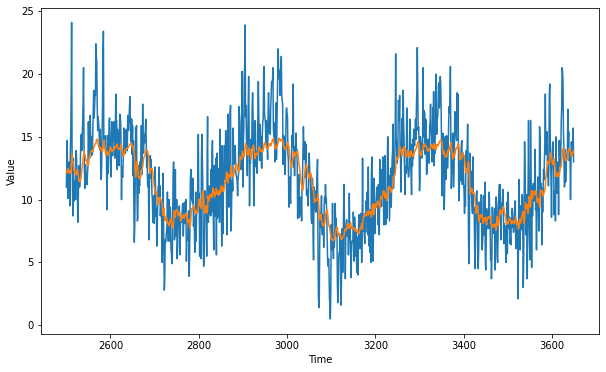

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.038099

In [ ]:
print(rnn_forecast)

[12.129942 12.242169 12.197648 ... 13.758008 13.74844  13.884151]
